# This notebook focuses on the metadata for tremor

In [1]:
baseDIR = '/home/pataki/synapse/gitParkinson' # base directory of the github repo

In [2]:
cd $baseDIR/sub2.1_tremor/

/home/pataki/synapse/gitParkinson/sub2.1_tremor


In [3]:
%run -i ../src/helperFuncs.py

In [4]:
%matplotlib inline

In [5]:
mainDF = mainDFCreator('tremorScore')

Train shape: (3667, 12)
Test shape:  (1500, 12)
Merged:      (5167, 12)


In [6]:
mainDF.groupby(['site', 'tremorScore']).count()[['session']].rename(columns={'session':'count'})

count
site   tremorScore       
Boston 0.0            927
       1.0            784
       2.0            406
       3.0             38
       4.0             12
       Score          960
NYC    0.0           1405
       1.0             94
       2.0              1
       Score          540

In [7]:
#returns a heatmap of a pivot table. the two dimensions are the feat1 and feat2. 
#value is the hitRate (#pos/(#pos + #neg))
def featPivot(feat1, feat2, mainDF, vmin, vmax): # vmin, vmax is for the color scale
    tmpDF = mainDF.reset_index(drop=True).reset_index()[['index', feat1, feat2, 'tremorScore']]
    
    tmpDF = tmpDF[tmpDF.tremorScore != 'Score'] # I focus only on 0.0 and 1.0
    tmpDF['tremorScore'] = [int(i>0) for i in tmpDF.tremorScore] # 1-2-3-4 is 1, 0 is 0
   
    tmpDF = tmpDF.groupby([feat1, feat2, 'tremorScore']).count().reset_index()
    sc1 = tmpDF[tmpDF.tremorScore == 1.0][[feat1, feat2, 'index']].rename(columns = {'index': 'score1'})
    sc0 = tmpDF[tmpDF.tremorScore == 0.0][[feat1, feat2, 'index']].rename(columns = {'index': 'score0'})
    tmpDF = pd.merge(sc1, sc0, on = [feat1, feat2], how = 'outer').fillna(0)

    tmpDF['hitRate'] = tmpDF.score1 / (tmpDF.score1 + tmpDF.score0)
    tmpDF = tmpDF.pivot(index = feat1, columns = feat2, values = 'hitRate')

    mask = tmpDF.isnull()
    sns.heatmap(tmpDF, mask = mask, 
                cmap = sns.dark_palette("muted purple", input="xkcd"), vmin = vmin, vmax = vmax)
    plt.show()

## Check the meta features if they contain useful information

['device', 'patient', 'session', 'site', 'task', 'visit', 'deviceSide']


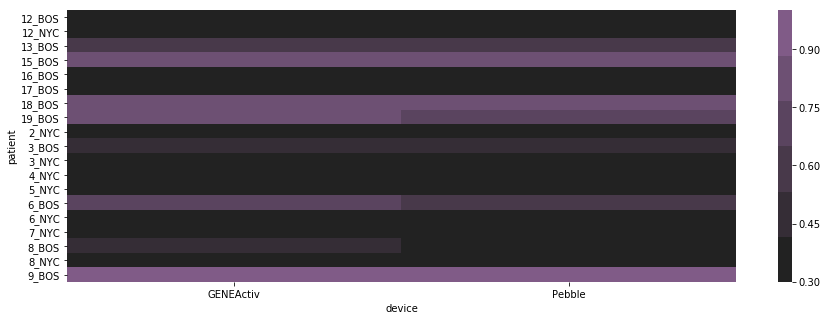

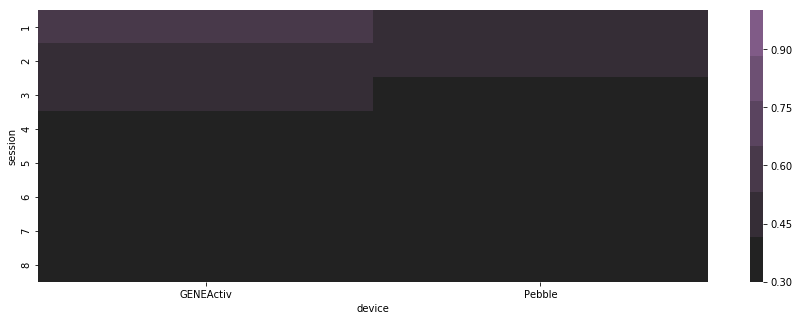

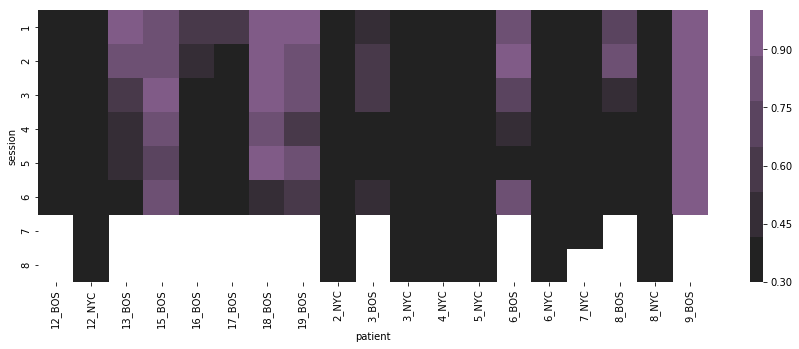

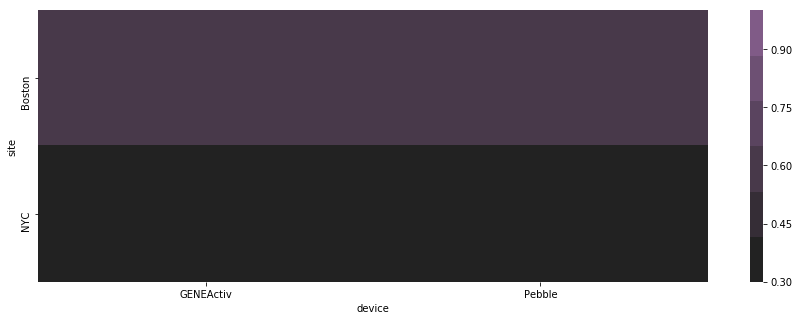

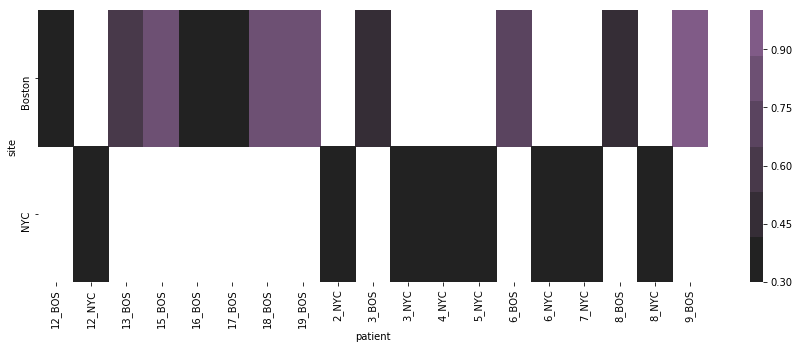

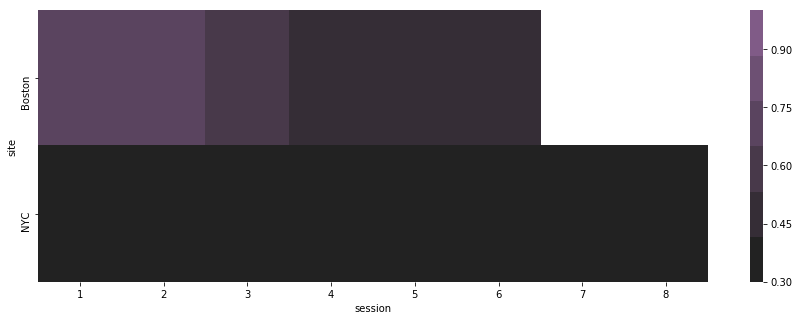

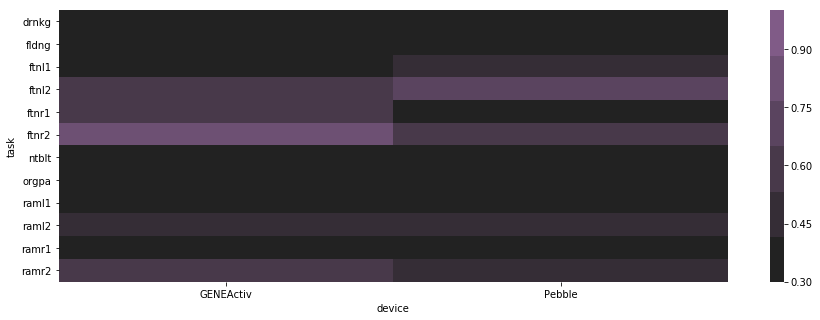

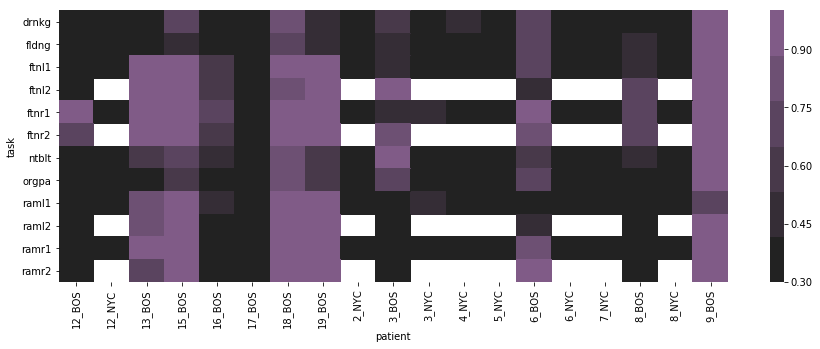

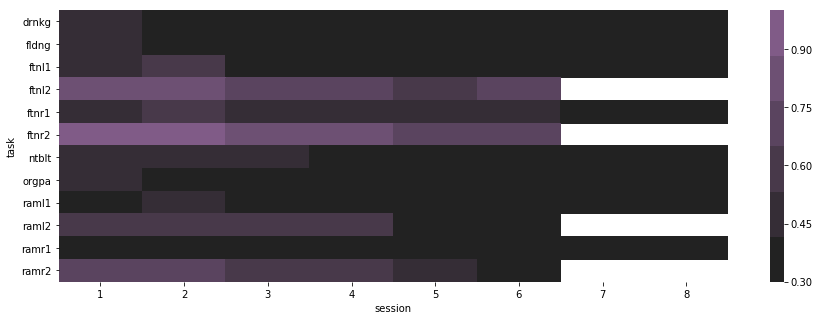

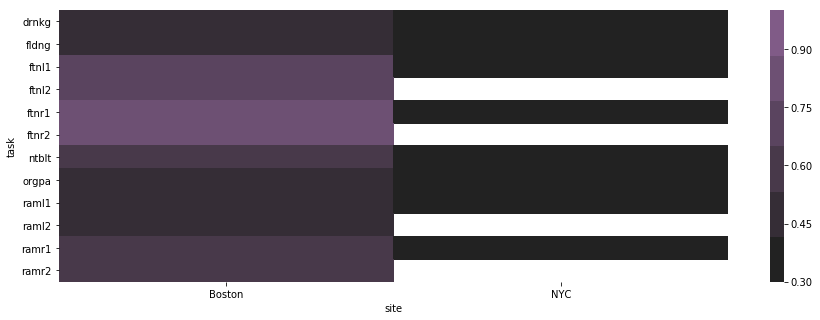

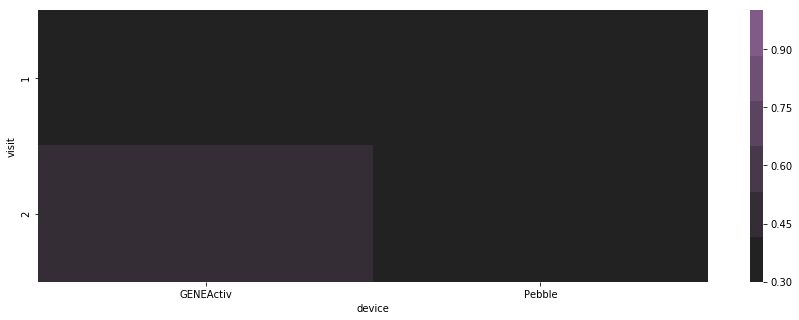

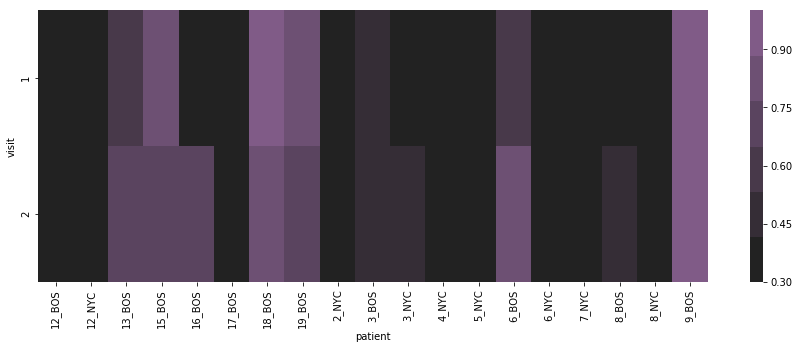

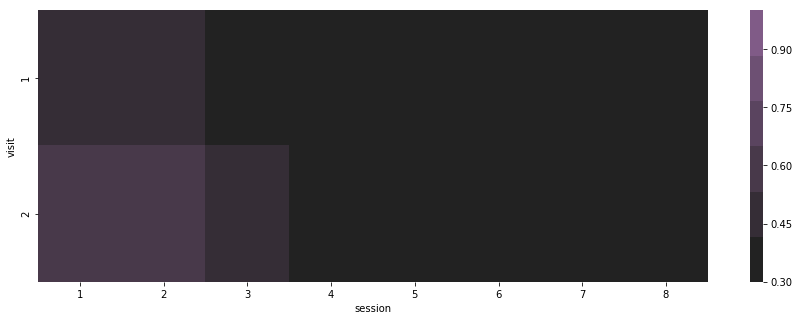

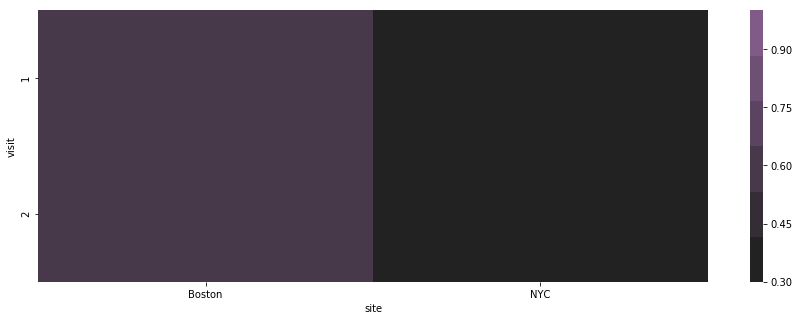

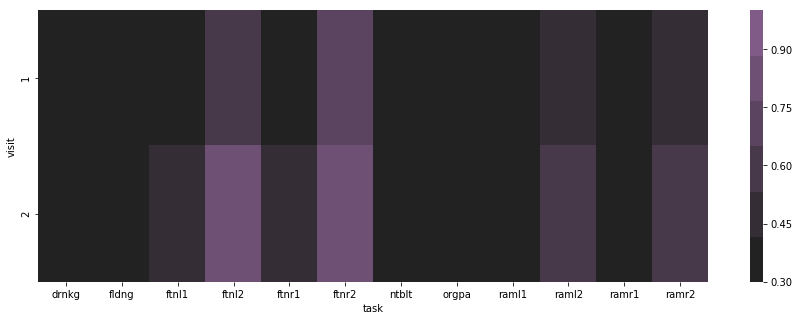

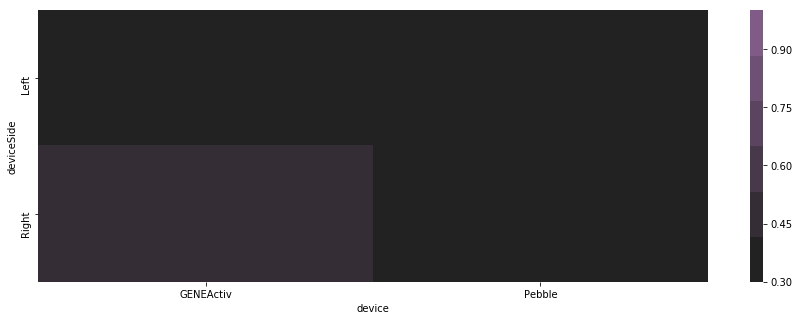

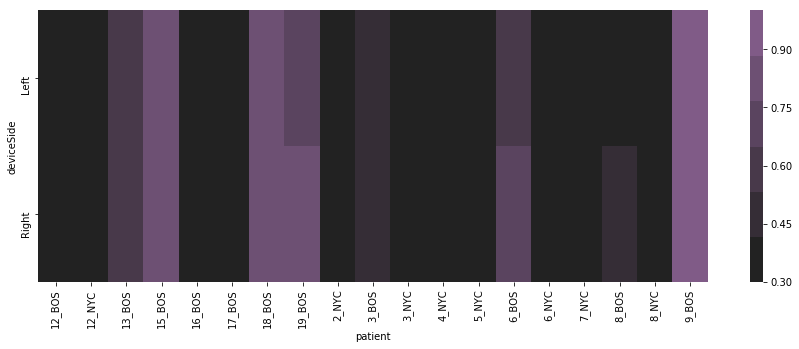

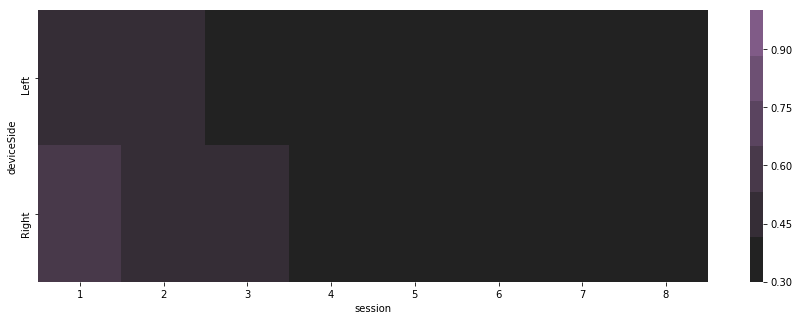

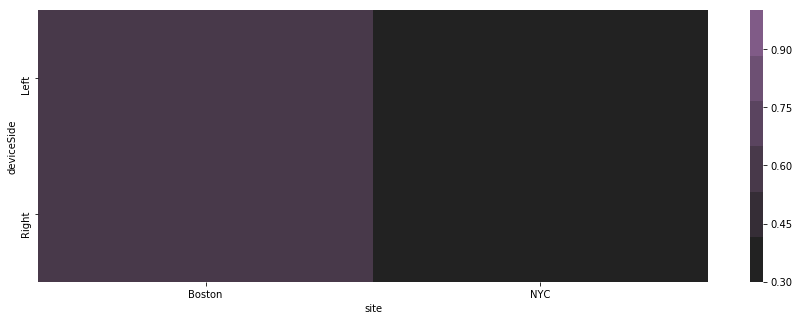

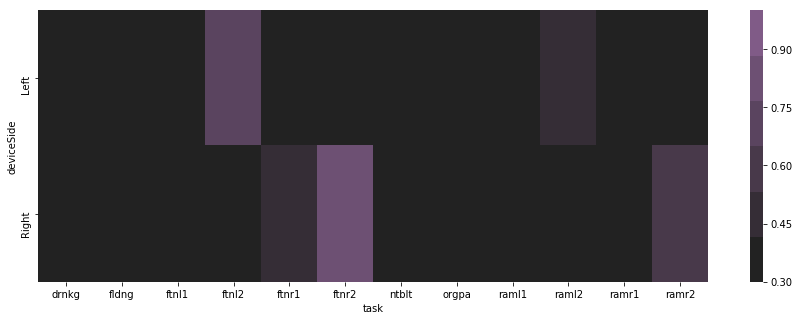

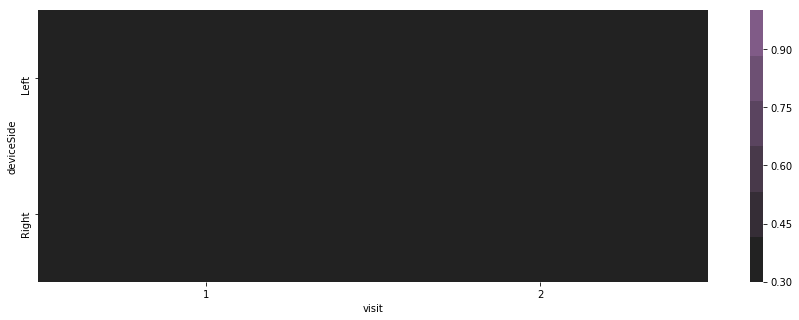

In [8]:
plt.rcParams['figure.figsize']=(15,5)

features = mainDF.columns.tolist()[2:-1]
print(features)
for i in range(len(features)):
    for j in range(len(features)):
        if(i > j):
            plt.subplot()
            subPlot = featPivot(features[i], features[j], mainDF, 0.3, 1.0)

In [9]:
nonTrivial = mainDF
count0 = nonTrivial[(nonTrivial.tremorScore == 0.0) & (nonTrivial.site == 'Boston')].groupby('session').count()[['site']].rename(columns={'site':'BOS0count'}).reset_index()
count1 = nonTrivial[(nonTrivial.tremorScore == 1.0) & (nonTrivial.site == 'Boston')].groupby('session').count()[['site']].rename(columns={'site':'BOS1count'}).reset_index()

BOSsessDF = pd.merge(count0, count1, on='session', how='outer').fillna(0)
BOSsessDF['BOShitRate'] = BOSsessDF['BOS1count']/(BOSsessDF['BOS0count'] + BOSsessDF['BOS1count'])

count0 = nonTrivial[(nonTrivial.tremorScore == 0.0) & (nonTrivial.site == 'NYC')].groupby('session').count()[['site']].rename(columns={'site':'NYC0count'}).reset_index()
count1 = nonTrivial[(nonTrivial.tremorScore == 1.0) & (nonTrivial.site == 'NYC')].groupby('session').count()[['site']].rename(columns={'site':'NYC1count'}).reset_index()

NYCsessDF = pd.merge(count0, count1, on='session', how='outer').fillna(0)
NYCsessDF['NYChitRate'] = NYCsessDF['NYC1count']/(NYCsessDF['NYC0count'] + NYCsessDF['NYC1count'])

pd.merge(NYCsessDF, BOSsessDF, on ='session', how='outer')
# hitrate table for session/site

,session,NYC0count,NYC1count,NYChitRate,BOS0count,BOS1count,BOShitRate
0,1,168,23.0,0.120419,95.0,145.0,0.604167
1,2,174,18.0,0.093750,111.0,149.0,0.573077
2,3,176,16.0,0.083333,144.0,139.0,0.491166
3,4,179,13.0,0.067708,187.0,111.0,0.372483
4,5,184,8.0,0.041667,190.0,123.0,0.392971
5,6,192,0.0,0.000000,200.0,117.0,0.369085
6,7,172,8.0,0.044444,NaN,NaN,NaN
7,8,160,8.0,0.047619,NaN,NaN,NaN


In [10]:
mainDF[(mainDF.visit==2) & 
       (mainDF.session.isin([1, 2]))].groupby(['site', 
                                               'tremorScore'])[['fileName']].count().rename(columns={'fileName':
                                                                                                     'count'})

count
site   tremorScore       
Boston 0.0             75
       1.0            160
       2.0            108
       3.0              9
       4.0              8
       Score          160
NYC    0.0            159
       1.0             32
       2.0              1
       Score           72

In [11]:
mainDF[(mainDF.visit==2) & 
       (mainDF.task.isin(['ftnl1', 'ftnl2', 'ftnr1', 'ftnr2']))].groupby(['site', 
                                               'tremorScore'])[['fileName']].count().rename(columns={'fileName':
                                                                                                     'count'})

count
site   tremorScore       
Boston 0.0             50
       1.0            156
       2.0             72
       3.0              1
       Score          120
NYC    0.0            102
       1.0             21
       2.0              1
       Score           42

## empirical feature #1: ftn(l1/l2/r1/r2) + Boston
## empirical feature #2: visit==2 + session==(1 or 2) + Boston

In [12]:
empFeat1 = mainDF[mainDF.task.isin(['ftnl1', 'ftnl2', 'ftnr1', 'ftnr2']) & 
             (mainDF.site == 'Boston')].dataFileHandleId.tolist()
empFeat2 = mainDF[mainDF.session.isin([1, 2]) & mainDF.visit.isin([2]) & 
             (mainDF.site == 'Boston')].dataFileHandleId.tolist()
mainDF = mainDF[['dataFileHandleId']].copy()

mainDF['empiricalFeature1'] = [1.0 if i in empFeat1 else 0.0 for i in mainDF.dataFileHandleId.tolist()]
mainDF['empiricalFeature2'] = [1.0 if i in empFeat2 else 0.0 for i in mainDF.dataFileHandleId.tolist()]

mainDF.head()

,dataFileHandleId,empiricalFeature1,empiricalFeature2
0,17286028,0.0,0.0
1,17286030,0.0,0.0
2,17286034,0.0,0.0
3,17286036,0.0,0.0
5,17286042,1.0,0.0


In [14]:
mainDF.to_csv('featureDB/empiricalFeature.tsv', sep = '\t', index=False)

In [15]:
baseFeatureDF = mainDFCreator('tremorScore')

Train shape: (3667, 12)
Test shape:  (1500, 12)
Merged:      (5167, 12)


## binarizing metafeatures except for the session and visit

In [16]:
baseFeatureDF = featureBinarizer(baseFeatureDF, ['device', 'site', 'task', 'deviceSide'])
baseFeatureDF.head()

device ['GENEActiv' 'Pebble']
site ['Boston' 'NYC']
task ['drnkg' 'fldng' 'ftnl1' 'ftnl2' 'ftnr1' 'ftnr2' 'ntblt' 'orgpa' 'raml1'
 'raml2' 'ramr1' 'ramr2']
deviceSide ['Right' 'Left']


,dataFileHandleId,fileName,patient,session,visit,tremorScore,device_1,site_1,task_1,task_2,...,task_4,task_5,task_6,task_7,task_8,task_9,task_10,task_11,task_12,deviceSide_1
0,17286028,/home/pataki/.synapseCache/28/17286028/drnkg_G...,13_BOS,1,1,1,0,0,1,0,...,0,0,0,0,0,0,0,0,0,1
1,17286030,/home/pataki/.synapseCache/30/17286030/drnkg_P...,13_BOS,1,1,1,1,0,1,0,...,0,0,0,0,0,0,0,0,0,0
2,17286034,/home/pataki/.synapseCache/34/17286034/fldng_G...,13_BOS,1,1,2,0,0,0,1,...,0,0,0,0,0,0,0,0,0,1
3,17286036,/home/pataki/.synapseCache/36/17286036/fldng_P...,13_BOS,1,1,1,1,0,0,1,...,0,0,0,0,0,0,0,0,0,0
5,17286042,/home/pataki/.synapseCache/42/17286042/ftnl1_P...,13_BOS,1,1,2,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [17]:
baseFeatureDF.pop('patient');
baseFeatureDF.pop('fileName');
baseFeatureDF.pop('tremorScore');

In [18]:
baseFeatureDF.to_csv('featureDB/baseFeatures.tsv', sep = '\t', index=False)